In [6]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


# Máscaras

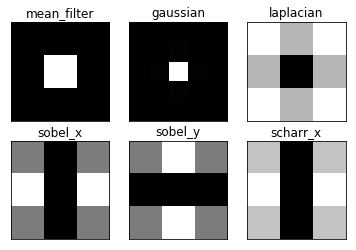

In [7]:
# simple averaging filter without scaling parameter
mean_filter = np.ones((3,3))

# creating a guassian filter
x = cv2.getGaussianKernel(5, 10)
gaussian = x*x.T

# different edge detecting filters
# scharr in x-direction
scharr = np.array([[-3, 0, 3],
                   [-10,0,10],
                   [-3, 0, 3]])

# sobel in x direction
sobel_x= np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])

# sobel in y direction
sobel_y= np.array([[-1,-2,-1],
                   [0, 0, 0],
                   [1, 2, 1]])
# laplacian
laplacian=np.array([[0, 1, 0],
                    [1,-4, 1],
                    [0, 1, 0]])

filters = [mean_filter, gaussian, laplacian, sobel_x, sobel_y, scharr]
filter_name = ['mean_filter', 'gaussian','laplacian', 'sobel_x', \
                'sobel_y', 'scharr_x']
fft_filters = [np.fft.fft2(x) for x in filters]
fft_shift = [np.fft.fftshift(y) for y in fft_filters]
mag_spectrum = [np.log(np.abs(z)+1) for z in fft_shift]

for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(mag_spectrum[i],cmap = 'gray')
    plt.title(filter_name[i]), plt.xticks([]), plt.yticks([])

plt.show()

# Aplicando máscara no domínio da frequência

### pré-processamento

In [9]:
img = cv2.imread('../bandeira_brasil.jpeg', 0)

#dimensoes
l = img.shape[0]
c = img.shape[1]

#fft usando opencv e shift com numpy
##Com o metodo cv2.dft(...) o resultado e um array com dois canais, 
##sendo um array para o eixo real e outro para o imaginario
##A imagem precisa ser float
img_fft = np.fft.fftshift((cv2.dft(np.float32(img),flags = cv2.DFT_COMPLEX_OUTPUT)))


#mascara redimensionada (valores movidos para o centro)
filter_mask = np.zeros((l,c))
filter_mask[(l//2)-1:int(np.ceil(l/2))+1,(c//2)-1:int(np.ceil(c/2))+1] = sobel_x
#filter_mask = grady

## Máscara no dominio da frequencia (fft e shift)

In [12]:
%time
fft_mask = np.fft.fftshift(cv2.dft(np.float32(filter_mask),flags = cv2.DFT_COMPLEX_OUTPUT))
mask_abs = cv2.magnitude(fft_mask[:,:,0],fft_mask[:,:,1])

#Normaliza valores para o intervalo 0-255 (opcional)
mask_abs_norm = cv2.normalize(mask_abs,  None, 0, 255, cv2.NORM_MINMAX)


#replica a magnitude da mascara para os dois canais
fft_mask[:,:,0] = mask_abs_norm
fft_mask[:,:,1] = mask_abs_norm

#filtra no dominio da frequencia
fft_filtered = cv2.multiply(img_fft, fft_mask)

#inverte a FFT
img_back = cv2.idft(np.fft.ifftshift(fft_filtered))
img_back = cv2.magnitude(img_back[:,:,0], img_back[:,:,1])

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


### Plot

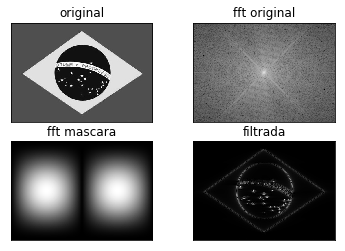

In [13]:
#diferenca em relacao a imagem original
#img_dif = cv2.normalize(img_back,  None, 0, 255, cv2.NORM_MINMAX)
#img_dif = cv2.subtract(np.float32(img),img_dif)

#image plot
imagens = [img,
           20 * np.log(cv2.magnitude(img_fft[:,:,0],img_fft[:,:,1])),
           mask_abs,
           img_back]

titles = ['original','fft original','fft mascara','filtrada']
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(imagens[i],cmap = 'gray')
    plt.title(titles[i]), plt.xticks([]), plt.yticks([])

plt.show()

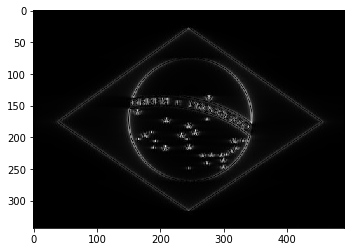

In [14]:
plt.imshow(img_back, cmap='gray');

# Aplicando máscara via convolução

CPU times: user 22.6 ms, sys: 116 µs, total: 22.7 ms
Wall time: 21.1 ms


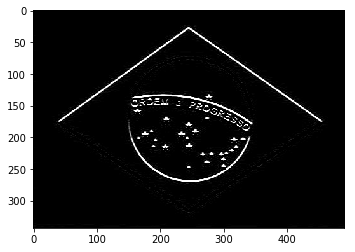

In [25]:
%%time
plt.imshow(cv2.filter2D(img, -1, sobel_y), cmap='gray')